# Load packages

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

In [2]:
color_dict = {
    0 : 'gray',
    1 : 'blue',
    2 : 'green',
    3 : 'yellow',
    4 : 'red'
}

label_dict = {
    0 : 'none',
    1 : 'flat',
    2 : 'stepped',
    3 : 'chute',
    4 : 'falls'
}

# Load data

In [3]:
tab_data_path = "C:\\Users\\joanm\\OneDrive - Dartmouth College\\Waterfalls\\Waterfalls_2022\\Waterfalls_data\\Waterfalls_tabular_data\\tabular_data_watkins"

In [4]:
strat = pd.read_csv(os.path.join(tab_data_path, "glen_strat.csv"))
profile = pd.read_csv(os.path.join(tab_data_path, "glen_profile.csv"))
widths = pd.read_csv(os.path.join(tab_data_path, "glen_widths.csv"))
morph = pd.read_csv(os.path.join(tab_data_path, "glen_morph.csv"))

# Functions

In [5]:
def channel_attributes(profile, widths, morph):
    profile.loc[profile.slope == 0.0 ,'slope'] = 0.0001
    
    profile_join = profile.merge(widths, how="left", left_on="distance", right_on="Distance")
    
    profile_join['Morph'] = 0
    for row in range(len(profile_join)):
        for row2 in range(len(morph)):
            if profile_join['elevation'].iloc[row] < morph['Seg. Top'].iloc[row2] and profile_join['elevation'].iloc[row] > morph['Seg. Bottom'].iloc[row2]:
                profile_join['Morph'].iloc[row] = morph['Morph type'].iloc[row2]  
    
    return profile_join

In [6]:
def bin_attributes(profile_join):
    bin_size = 1.0
    # In m, the bin height of elevation data 
    
    # Make bin edges the rounded highest and lowest elevation stepped by bin_size
    bin_edges = np.arange(round(strat.bed_center_elev.min(),0), round(strat.bed_center_elev.max(),0), bin_size)

    # Bin strat
    strat_bin_mean = strat.groupby(pd.cut(strat.bed_center_elev, bin_edges)).bed_thickness.mean()
    strat_bin_max = strat.groupby(pd.cut(strat.bed_center_elev, bin_edges)).bed_thickness.max()
    strat_bin_std = strat.groupby(pd.cut(strat.bed_center_elev, bin_edges)).bed_thickness.std()
    
    #Bin slope and width
    slope_bin_mean = profile_join.groupby(pd.cut(profile_join.elevation, bin_edges)).slope.mean()
    slope_bin_max = profile_join.groupby(pd.cut(profile_join.elevation, bin_edges)).slope.max()
    slope_bin_std = profile_join.groupby(pd.cut(profile_join.elevation, bin_edges)).slope.std()

    width_bin_mean = profile_join.groupby(pd.cut(profile_join.elevation, bin_edges)).width.mean()
    width_bin_max = profile_join.groupby(pd.cut(profile_join.elevation, bin_edges)).width.max()
    width_bin_std = profile_join.groupby(pd.cut(profile_join.elevation, bin_edges)).width.std()
    
    # Assign morphs to bins
    morph_bin = np.zeros(len(bin_edges)-1)
    for row in range(len(bin_edges)):
        for row2 in range(len(morph)):
            if bin_edges[row] < morph['Seg. Top'].iloc[row2] and bin_edges[row] > morph['Seg. Bottom'].iloc[row2]:
                morph_bin[row] = morph['Morph type'].iloc[row2]
                
    #binned_data_means = pd.DataFrame(strat_bin_mean, columns=['bed_thickness_mean'])
    binned_data_means = pd.DataFrame(strat_bin_mean)
    binned_data_means['elev_lower_bin'] = bin_edges[:-1]

    binned_data_means['bed_thickness_max'] = strat_bin_max 

    binned_data_means['slope_mean'] = slope_bin_mean
    binned_data_means['width_mean'] = width_bin_mean
    binned_data_means['morph'] = morph_bin
    binned_data_means['s/w'] = binned_data_means['slope_mean']/binned_data_means['width_mean']
    # There are a lot of NaNs but that's OK 
    
    return binned_data_means

In [7]:
def force_balance(binned_data_means):
    Fstar_L = 0.85;
    phi=35;
    Cd=1;
    Cf = .7;
    Pr = 2700;
    Pw = 1000;
    g = 9.8;

    P = 0.075; 
    zo = .0025; 

    u_u_star = (1/0.41)*np.log(P/zo);

    H = binned_data_means.bed_thickness_max;
    #L = H/(-0.0044*(binned_data_means.elev_lower_bin)+1.2712); # placeholder fracture spacing/bed height ratio function
    L = H*3 # Simpler. 
    W=L;

    slope = (binned_data_means.slope_mean);
    tan_theta = slope;
    theta = np.tan(tan_theta);

    # Calculate terms from loaded data
    taustar_w_nond = L*W*H*Cf*Pr*g*np.cos(theta);
    taustar_w = taustar_w_nond/((Pr-Pw)*g*W);
    
    # Model motion 
    binned_data_means['entrain_taustar'] = (np.cos(theta) + 2*taustar_w*(1+(W/L)))/(Fstar_L*(1+(0.5*Cd)*((u_u_star)**2)*(P/L)))

    binned_data_means['topple_taustar'] = ((np.cos(theta))*(np.tan(phi)-np.tan(theta))+(2.*taustar_w))/((1+(0.5*Cd)*((u_u_star)**2)*(P/L))*(1+(Fstar_L*np.tan(phi))))

    binned_data_means['slide_taustar'] = ((L/H)*np.cos(theta)*(1-(H/L)*np.tan(phi))+taustar_w)/((1+(0.5*Cd)*((u_u_star)**2)*(P/L))*(1+(0.5*Fstar_L*(L/H)*(np.cos(theta)))));

    binned_force_balance = binned_data_means
    return binned_force_balance

# Run functions and plot

In [8]:
profile_join = channel_attributes(profile, widths, morph)

C:\Users\joanm\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
binned_data_means = bin_attributes(profile_join)

In [10]:
binned_force_balance = force_balance(binned_data_means)

C:\Users\joanm\Anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


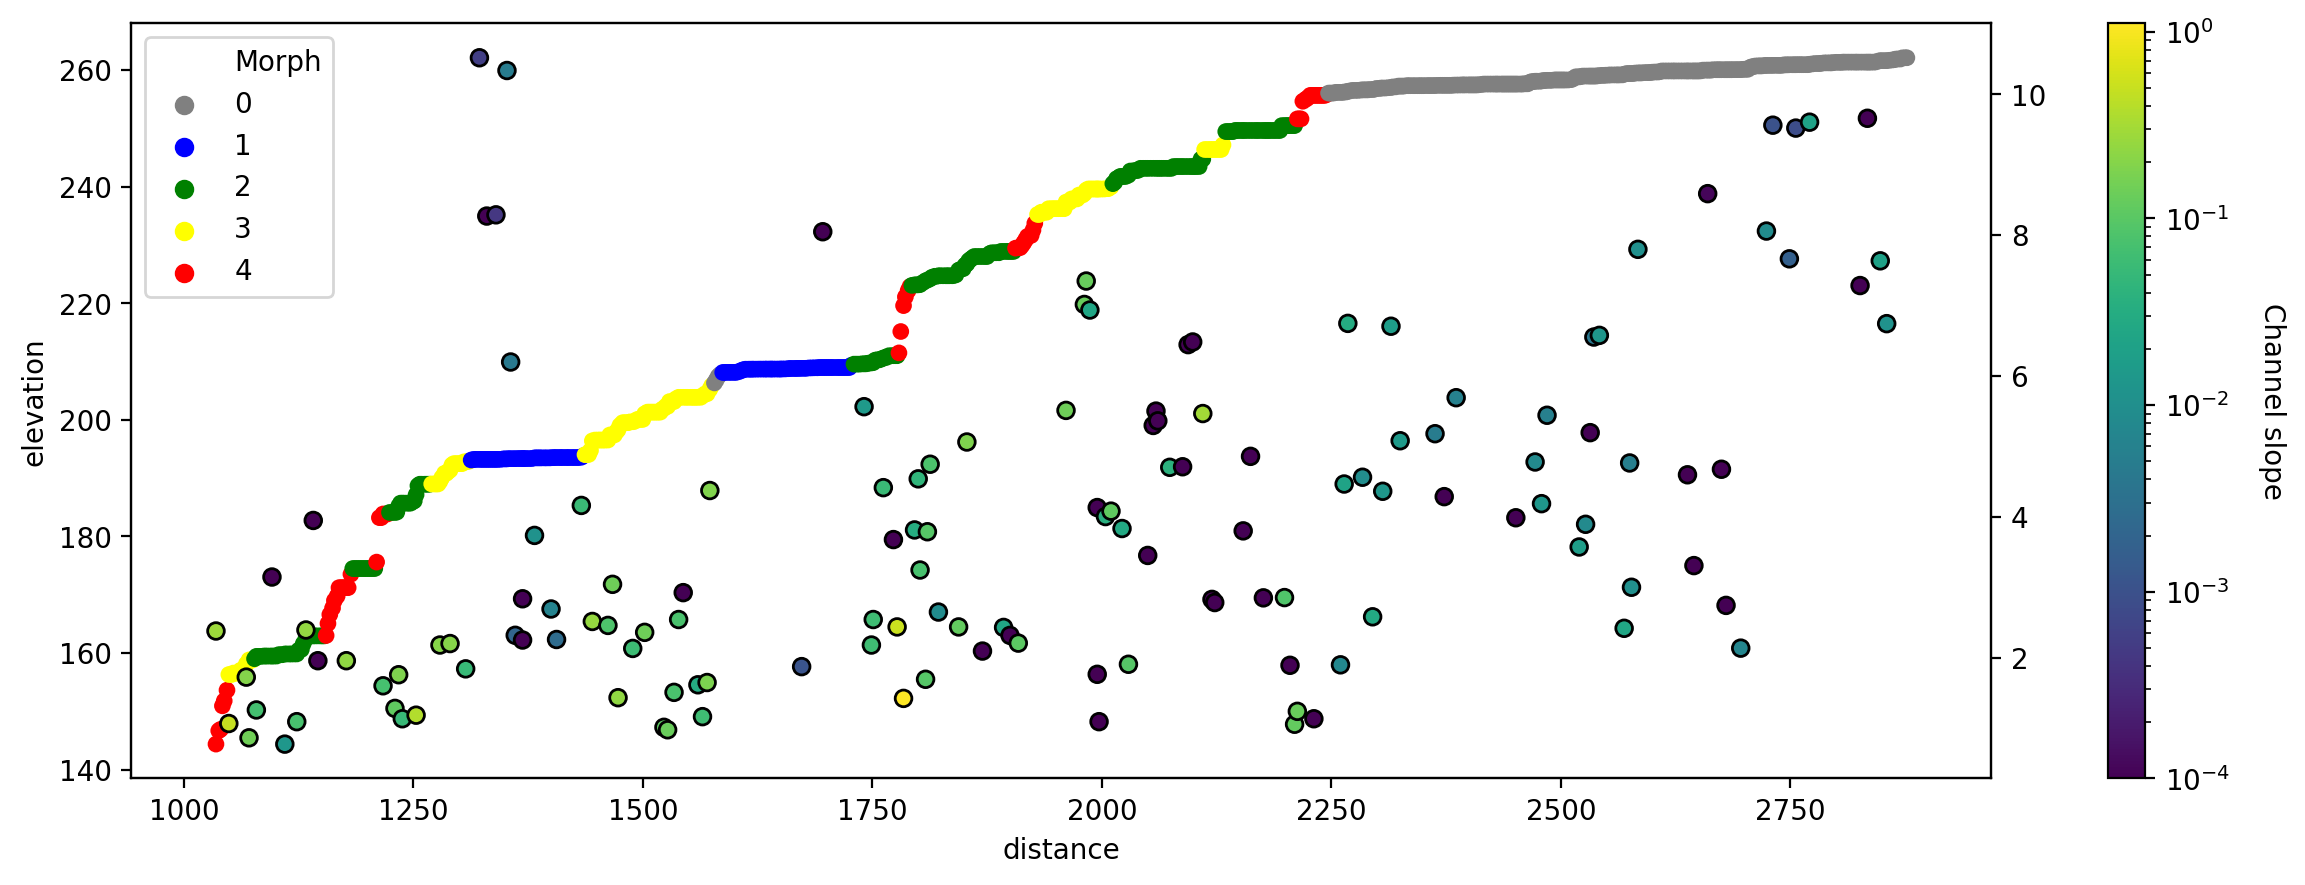

In [11]:
fig, ax = plt.subplots(figsize=(15,5), dpi=200)
im0 = sns.scatterplot(x='distance', y='elevation', data=profile_join, hue='Morph', palette=color_dict,edgecolor="none")
ax2 = ax.twinx()
im = ax2.scatter(profile_join.distance, profile_join.width, c=profile_join.slope, norm=colors.LogNorm(), edgecolor='k')
cb = fig.colorbar(im, ax=ax2)
cb.set_label('Channel slope', rotation=270, labelpad=20);

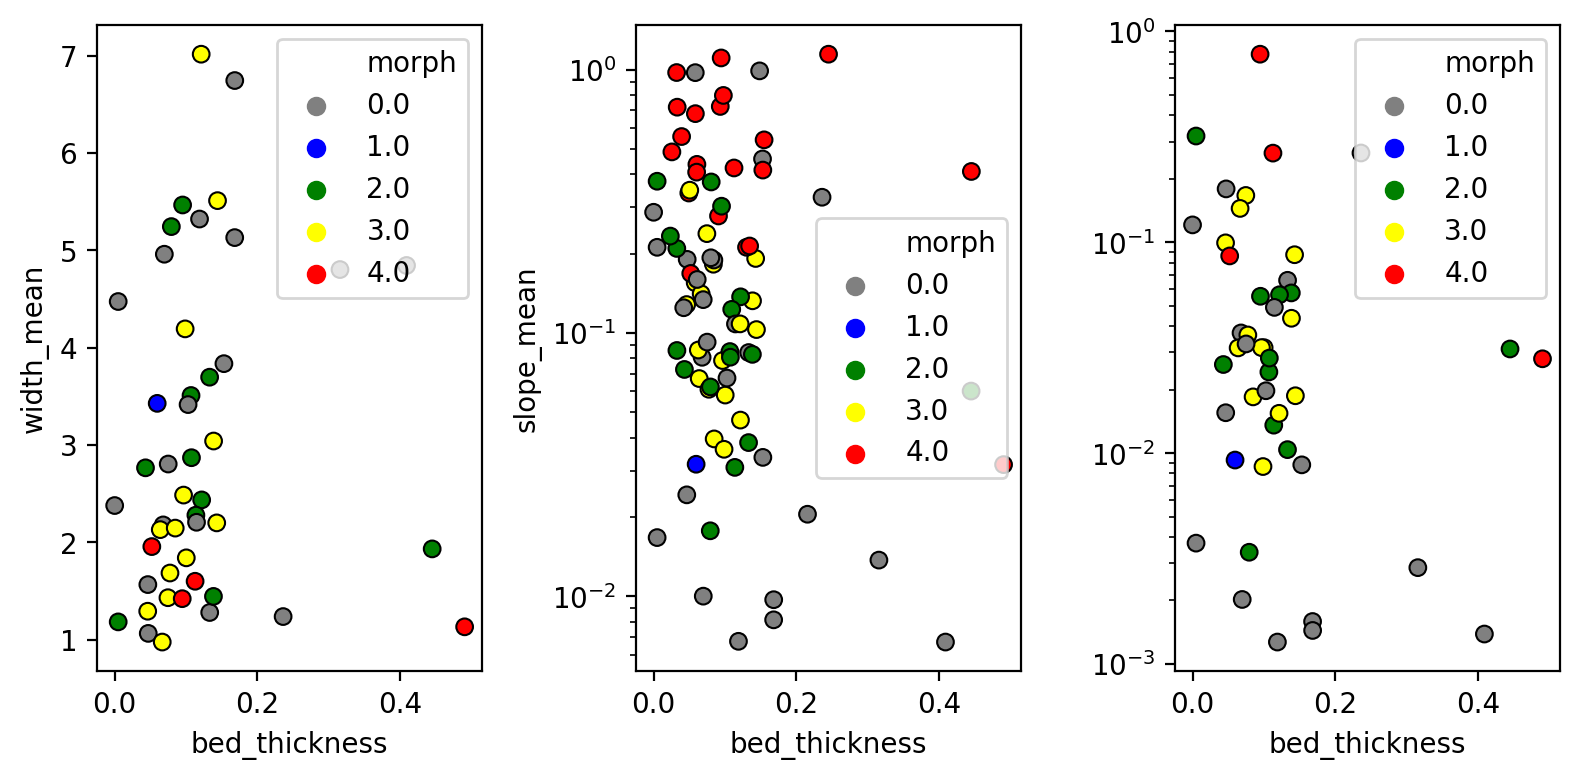

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(8,4), dpi=200)

sns.scatterplot(data=binned_data_means, x='bed_thickness', y='width_mean', hue='morph', palette=color_dict,edgecolor="black", ax=ax[0])
sns.scatterplot(data=binned_data_means, x='bed_thickness', y='slope_mean', hue='morph', palette=color_dict,edgecolor="black", ax=ax[1])
sns.scatterplot(data=binned_data_means, x='bed_thickness', y=binned_data_means.slope_mean/binned_data_means.width_mean, hue='morph', palette=color_dict,edgecolor="black", ax=ax[2])

ax[1].set_yscale("log")
ax[2].set_yscale("log")

fig.tight_layout()

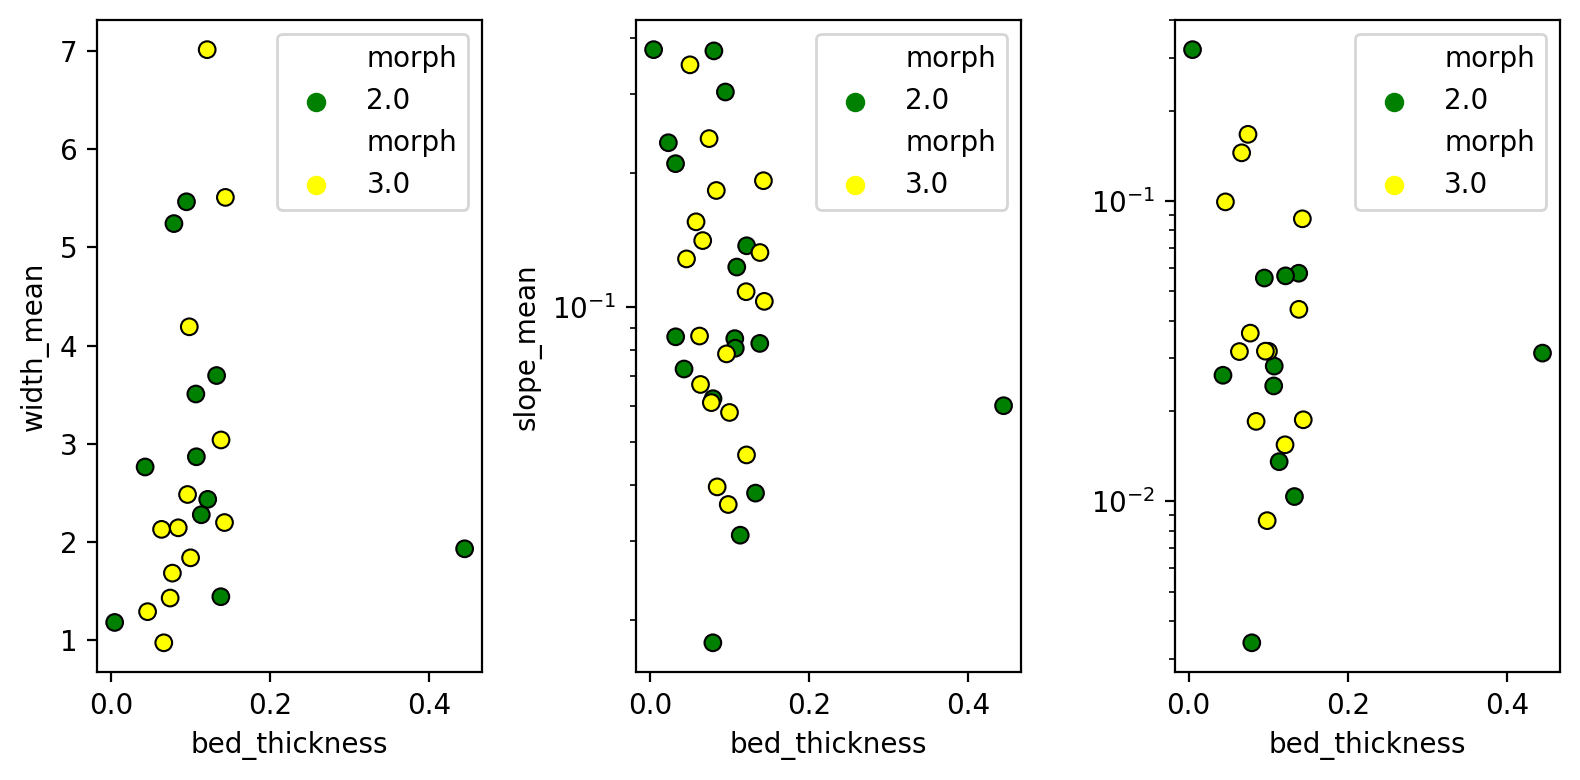

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(8,4), dpi=200)

steps = binned_data_means.query("morph == 2")
chutes = binned_data_means.query("morph == 3")

sns.scatterplot(data=steps, x='bed_thickness', y='width_mean', hue='morph', palette=color_dict,edgecolor="black", ax=ax[0])
sns.scatterplot(data=steps, x='bed_thickness', y='slope_mean', hue='morph', palette=color_dict,edgecolor="black", ax=ax[1])
sns.scatterplot(data=steps, x='bed_thickness', y=steps.slope_mean/steps.width_mean, hue='morph', palette=color_dict,edgecolor="black", ax=ax[2])

sns.scatterplot(data=chutes, x='bed_thickness', y='width_mean', hue='morph', palette=color_dict,edgecolor="black", ax=ax[0])
sns.scatterplot(data=chutes, x='bed_thickness', y='slope_mean', hue='morph', palette=color_dict,edgecolor="black", ax=ax[1])
sns.scatterplot(data=chutes, x='bed_thickness', y=chutes.slope_mean/chutes.width_mean, hue='morph', palette=color_dict,edgecolor="black", ax=ax[2])

ax[1].set_yscale("log")
ax[2].set_yscale("log")

fig.tight_layout()

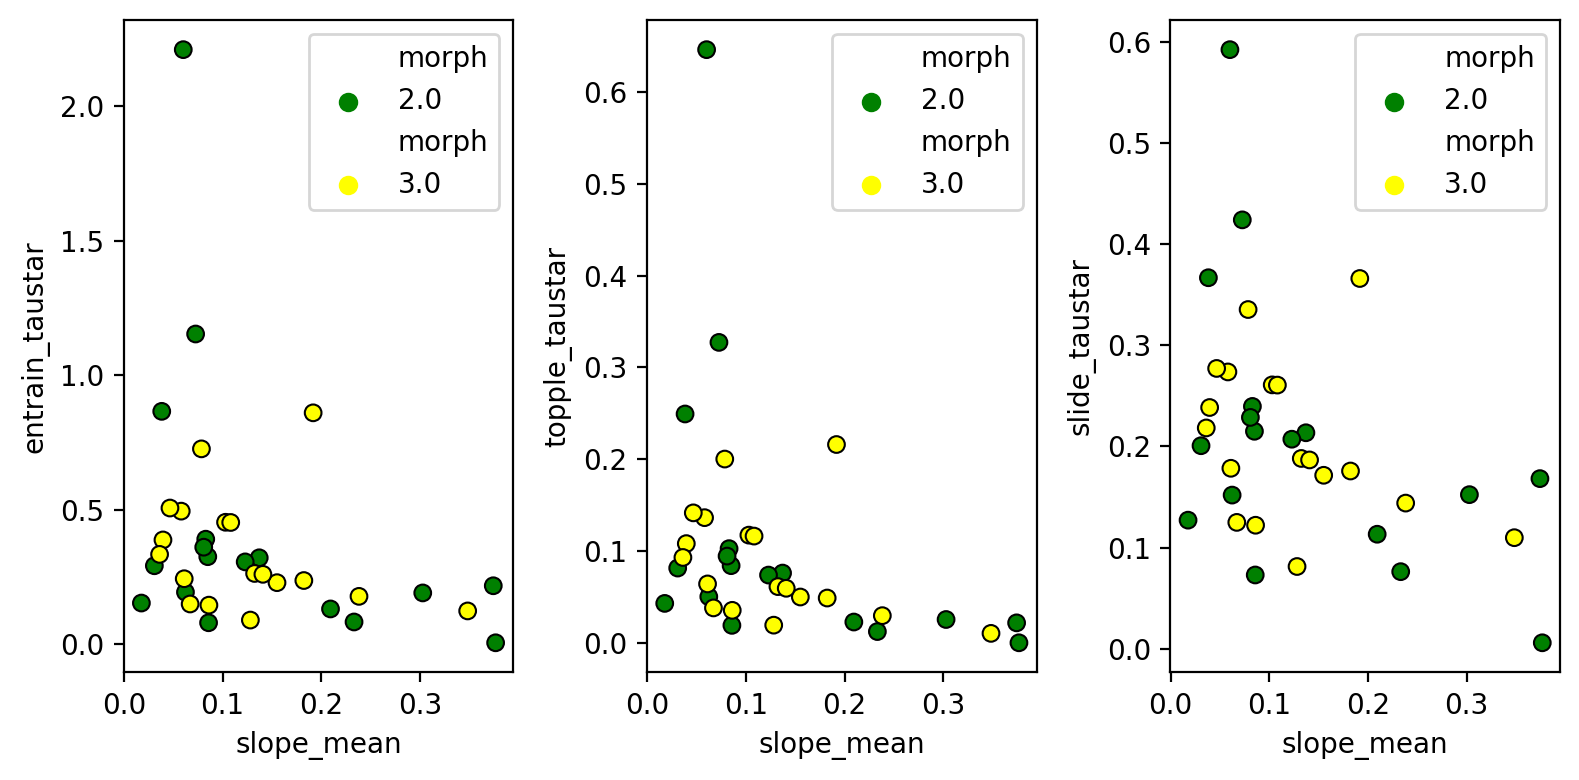

In [14]:
fig, ax = plt.subplots(1,3, figsize=(8,4), dpi=200)

steps = binned_force_balance.query("morph == 2")
chutes = binned_force_balance.query("morph == 3")


sns.scatterplot(data=steps, x='slope_mean', y='entrain_taustar',
                hue='morph', palette=color_dict,edgecolor="black", ax=ax[0])

sns.scatterplot(data=steps, x='slope_mean', y='topple_taustar',
                hue='morph', palette=color_dict,edgecolor="black", ax=ax[1])

sns.scatterplot(data=steps, x='slope_mean', y='slide_taustar',
                hue='morph', palette=color_dict,edgecolor="black", ax=ax[2])

sns.scatterplot(data=chutes, x='slope_mean', y='entrain_taustar',
                hue='morph', palette=color_dict,edgecolor="black", ax=ax[0])

sns.scatterplot(data=chutes, x='slope_mean', y='topple_taustar',
                hue='morph', palette=color_dict,edgecolor="black", ax=ax[1])

sns.scatterplot(data=chutes, x='slope_mean', y='slide_taustar',
                hue='morph', palette=color_dict,edgecolor="black", ax=ax[2])

fig.tight_layout()